In [1]:
library(dplyr)
library(tidyverse)
library(RColorBrewer)
library(GGally)
library(mltools)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.1     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



## Introduction

We will be using the sleep efficiency dataset:

https://www.kaggle.com/datasets/equilibriumm/sleep-efficiency in Kaggle, which contains 100 observations.

The data was collected in 2021 by a research team in the UK, and was collected from the University of Oxfordshire. It was collected from a local community over a period of several months using a combination of self-reported surveys, actigraphy, and polysomnography (a sleep monitoring technique). 

**Our research question and motivation behind the analysis of the data:**

Which variables are most important in predicting sleep efficiency? And how do these variables relate to sleep efficiency?

We use a forward selection process to determine which variables are most relevant for predicting sleep efficiency and build regression models based only on the variables selected. After comparing different models, we select the best model and use this model to predict the test dataset and combine it with the actual values to see how accurate our model is.

From the model, we can develop a general idea about what factors relate to sleep efficiency and how they are correlated. Therefore, it may suggest some methods to improve sleep patterns by controlling certain factors. 

In [15]:
sleep <- read.csv('Sleep_Efficiency.csv')

# Convert certain variables into categorical variables 
# Gender: male is encoded as 1, and female is encoded as 0
# Smoking status: Yes is encoded as 1, and No is encoded as 0
sleep <- sleep |>
    mutate(Caffeine.consumption = as.factor(Caffeine.consumption),
          Awakenings = as.factor(Awakenings),
          Alcohol.consumption = as.factor(Alcohol.consumption), 
          Smoking.status = as.factor(case_when(
              Smoking.status == 'Yes' ~ 1,
              Smoking.status == 'No' ~ 0,
              TRUE ~ NA)),
           Gender= as.factor(case_when(
              Gender == 'Male' ~ 1,
              Gender == 'Female' ~ 0,
              TRUE ~ NA)),
           Exercise.frequency = as.factor(Exercise.frequency)
          )

head(sleep)

,ID,Age,Gender,Bedtime,Wakeup.time,Sleep.duration,Sleep.efficiency,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<int>,<int>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,65,0,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0,0,0,1,3
2,2,69,1,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3,0,3,1,3
3,3,40,0,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1,0,0,0,3
4,4,40,0,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3,50,5,1,1
5,5,57,1,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3,0,3,0,3
6,6,36,0,2021-07-01 21:00:00,2021-07-01 04:30:00,7.5,0.90,23,60,17,0,NA,0,0,1


We included 12 variables:

*The response variable:*

>Sleep efficiency: a numerical variable ranging from 0 to 1 that indicates the proportion of time in bed spent asleep

*The explanatory variables:*

>1. Age: numerical variable ranges from 9 to 69
>2. Gender: categorical / dummy variable with 50% of the data is male and the rest half female
>3. Sleep duration: numerical variable indicating the total amount of time the test subject slept (in hours).
>4. Awakenings: categorical variable indicating the number of times the test subject wakes up during the night
>5. REM sleep percentage: numerical variable indicating the percentage of total sleep time spent in REM (rapid eye movement) sleep 
    - REM sleep is the stage where people have intense brain activities (dreams) and restores the areas of the brain that help with memory and learning. 20% of the total sleep time in the REM stage is considered good 
>6. Deep sleep percentage: numerical variable indicating the percentage of total sleep time spent in Deep (non - rapid eye movement) sleep 
    - Deep sleep is important for body to replenish energy stores and repair muscles, bones, and tissue. 15% to 25% of the total sleep time in the deep sleep stage is considered normal  
>7. Light sleep percentage:  numerical variable indicating the percentage of total sleep time spent in Light sleep
    - Light sleep is the transitional stage between waking and sleeping. Typically take up about 50% to 60% or more of the total sleep time     
>8. Caffeine consumption: categorical variable indicating the amount of caffeine consumed in the 24 hours prior to bedtime (in mg)
>9. Alcohol consumption: categorical variable indicating the amount of alcohol consumed in the 24 hours prior to bedtime (in oz)
>10. Smoking status: categorical / dummy variable that states whether or not the person smokes
>11. Exercise frequency: categorical variable indicating the number of times the person exercises each week

Although some explanatory variables appear as numerical (e.g. Alcohol consumption, Caffeine consumption), the number of values these variables take are limited. Therefore, we can view these variables as categorical with a few levels. 

In [3]:
sleep_data <- sleep |>
    select(-ID, -Bedtime, -Wakeup.time, -Light.sleep.percentage)
head(sleep_data)

,Age,Gender,Sleep.duration,Sleep.efficiency,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,65,1,6.0,0.88,18,70,12,0,0,0,1,3
2,69,1,7.0,0.66,19,28,53,3,0,3,1,3
3,40,1,8.0,0.89,20,70,10,1,0,0,0,3
4,40,1,6.0,0.51,23,25,52,3,50,5,1,1
5,57,1,8.0,0.76,27,55,18,3,0,3,0,3
6,36,1,7.5,0.90,23,60,17,0,NA,0,0,1


In [4]:
set.seed(123)

train_ind <- sample.int(nrow(sleep_data), size = nrow(sleep_data) * 0.70, replace = FALSE)

sleep_train <- sleep_data[train_ind,]
sleep_test <- sleep_data[-train_ind,]

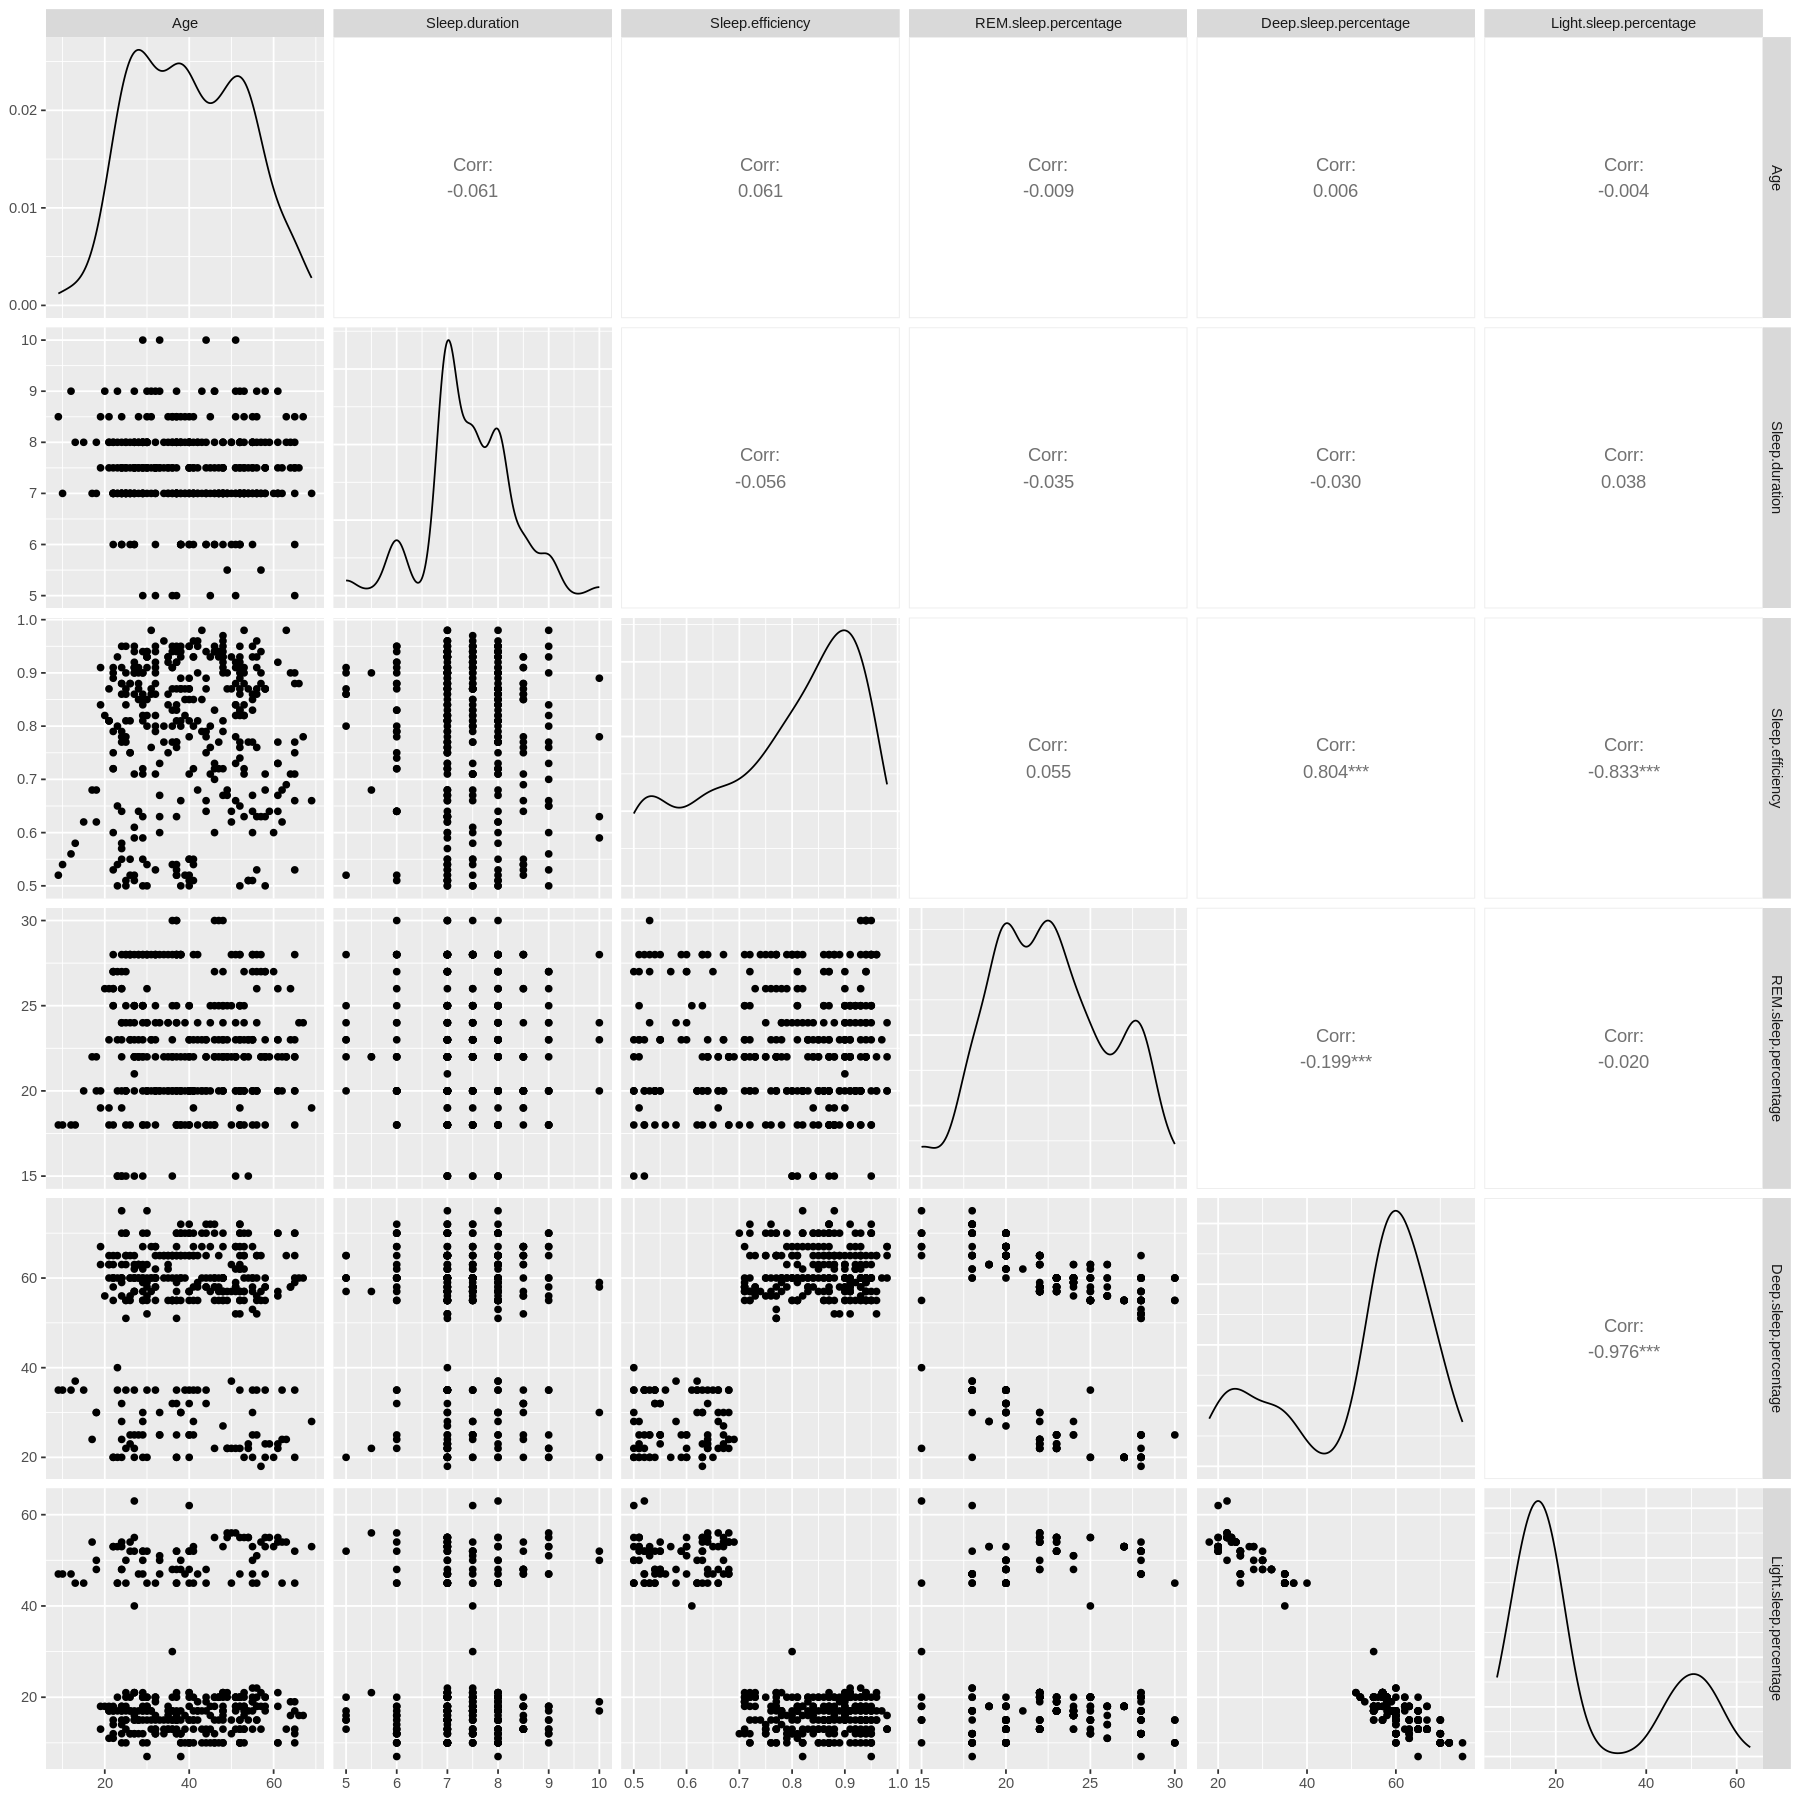

In [14]:
options(repr.plot.height = 15, repr.plot.width = 15)
sleep_train |>
    ggpairs(columns = c('Age', 'Sleep.duration', 'Sleep.efficiency', 'REM.sleep.percentage', 'Deep.sleep.percentage', 'Light.sleep.percentage'))

Looking at this ggpairs graph which only includes the numerical variables, we see that only deep sleep percentage and light sleep percentage are strongly correlated with the reponse variable (sleep efficiency). Their correlation are 0.804 and -0.833 respectively. 

Almost all the explanatory variables have no significant correlation with each other except deep sleep percentage and light sleep percentage. These two variables have a very strong correlation that is -0.976, and their correspong scatterplot also exbihits a strong negative linear relationship. This could result in a very problematic issue called collinearity. 

Therefore, we will perform a forward selection process to determine which set of variables will be included in the model building.  

Let's start by making a full model regression to have a comparison between our final selected model.

In [ ]:
full_regression <- lm(Sleep.efficiency ~., data = sleep_train)

full_reg_pred <- predict(full_regression, newdata = sleep_test)
sleep_R_MSE_models <- tibble(
  Model = "Full Regression",
  R_MSE = rmse(
    preds = full_reg_pred,
    actual = sleep_test$Sleep.efficiency,
    na.rm = TRUE))
sleep_R_MSE_models

# Here we compute Root Mean Squared Error so that we can use it as a
# comparison metric between best fit models

Now we can begin the forward selection process.
We also will compute values of RSS, BIC, and Cp to help decide which sized model is the best fit.

In [ ]:
sleep_forward_selection <- regsubsets(
  x = Sleep.efficiency ~., nvmax = 11,
  data = sleep_train,
  method = "forward")
sleep_forward_selection

sleep_forward_summary <- summary(sleep_forward_selection)

sleep_forward_summary_df <- tibble(
  n_input_variables = 1:11,
  RSS = sleep_forward_summary$rss,
  BIC = sleep_forward_summary$bic,
  Cp = sleep_forward_summary$cp)

In [ ]:
sleep_forward_summary_df
# We can see that the lowest Cp is with 7 variables
summary(sleep_forward_selection)

We found that the best model has 7 variables and found which ones from the chart above. Now we can put that into a model and compare it with the original.

In [ ]:
#make the model with 7 variables
sleep_selected_regression <- lm(Sleep.efficiency ~ Age + REM.sleep.percentage + Deep.sleep.percentage
                                + Awakenings + Alcohol.consumption + Smoking.status 
                                + Exercise.frequency, data = sleep_train)
summary(sleep_selected_regression)

#fit a predicted model
sleep_selected_reg_pred <- predict(sleep_selected_regression, newdata = sleep_test)

#Now we can compare the RMSE on the models
sleep_R_MSE_models <- rbind(
  sleep_R_MSE_models,
  tibble(
    Model = "Selected Regression",
    R_MSE = rmse(
      preds = sleep_selected_reg_pred,
      actuals = sleep_test$Sleep.efficiency,
      na.rm = TRUE)))
sleep_R_MSE_models

From here, we can find that the mdoel with the lowest RMSE value gives the best out-of-sample prediction performance. In this example, we can see that the regression model where we selected the variables using forward regression produces a better model. Here we showed that selecting variables helps improve the model, in which we used a forward selection process to find that.
We also found that in a model with 7 out of 11 selected variables: Gender, Sleep duration, and Caffeine Consumption were not as helpful in comparison to the other variables when predicting Sleep efficiency- which is an interesting discovery. It helps us to answer our research question which asks which variables are most important.
We were surprised to find that caffeine consumption wasn't as important to be kept in the model, as we found many studies when researching that implied the opposite.